### Explaination

This decision tree uses "entropy" to quantify the purity a subset of X where an entropy of 1 equates to equally represented classes and 0 equates to a single class only. The decision tree will choose the node/split that maximises the decrease in entropy from the whole set to the two subsets, this is called information gain. The model will continue this until each subset has entropy 0 or the maximum depth is reached.

The fitted decision tree is stored as a dictionary where each entry is a node on the tree. The node contains its splitting point and the relavent feature along with the ID numbers of the IDs of the succesive nodes. This makes predicting a point easy. When we reach a node we and compare the feature of our point to the split threshold and go to whichever node ID that corresponds to that result.If the node is a leaf node, then the dominant class of the subset is given as the final prediction.

This explaination would be a lot clearer with some notation.

### Import modules

In [126]:
import pandas as pd
import numpy as np
import math
from sklearn.datasets import make_blobs

### Make the data set

In [127]:
X, y = make_blobs(n_samples=20, random_state=42, n_features=2, cluster_std=3, centers=3)

<AxesSubplot:xlabel='x1', ylabel='x2'>

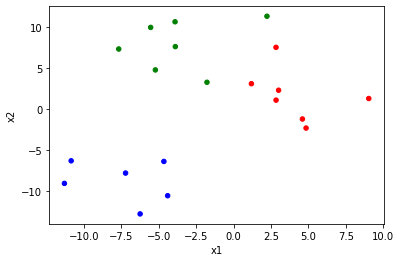

In [128]:
df = pd.DataFrame(X, columns=['x1', 'x2'])

df['y'] = y

col = df['y'].map({1:'r', 2:'b', 0:'g'})

df.plot(kind='scatter', x='x1', y='x2', c=col)


### Create the class

In [116]:
class dt():
    def __init__(self, max_depth):
        self.split_d = {}
        self.max_depth = max_depth

    # proportion function for a class
    def prop1(self, array, class_):
        if array.shape[0] == 0:
            return 0
        return array[array == class_].shape[0]/array.shape[0]
    
    # proportion function for a split point
    def prop2(self, array, split):
        if array.shape[0] == 0:
            return 0
        return array[array < split].shape[0]/array.shape[0]

    # entropy function
    def entropy(self, y):
        total = 0
        for class_ in np.unique(y):
            n = self.prop1(y, class_)
            if n==0:
                continue
            total -= (n*math.log(n, 2))
        return total

    # information gain function
    def ig(self, X, y, split_point):
        result = self.entropy(y) - ((self.prop2(X, split_point)*self.entropy(y[X < split_point])) + (((1-self.prop2(X, split_point))*self.entropy(y[X >= split_point]))))
        return result

    # find best split
    def fbs(self, X, y):
        # top split is [ig, feature (int), feature split]
        top_split = np.zeros(3)
        # cycle through each feature
        for i, x in enumerate(X.T):
            # cycle through each feature split
            for f_s in np.unique(x):
                result = self.ig(x, y, f_s)
                if result > top_split[0]:
                    top_split = [result, i, f_s]
        # returns (ig, feature number, feature split)
        return top_split

    def fit(self, X, y):
        layer_list = [[]]
        
        self.split_d = {}

        finished = False

        split_id = 0

        # each list in layer_list holds the splits for that layer
        # a split has (X for that split, y for that split, feature number. feature split, direction of split)
        layer_list[0].append((X, y, 'null', 'null', split_id, 'null'))

        layer = 0

        # make the decision tree
        while not finished:
            # add a new layer
            layer_list.append([])
            layer += 1
            for split in layer_list[layer-1]:

                X_temp = split[0]
                y_temp = split[1]
                

                # if only one class left then move on
                if (len(np.unique(y_temp)) < 2) or (layer > self.max_depth):
                    # a leaf node with format [0, 0, class_id, finished]
                    if split[5] == 0:
                        self.split_d[split[4]] = [0, 0, 0, pd.DataFrame(y_temp[X_temp[:,split[2]] < split[3]]).value_counts().index[0][0], 1]
                    else:
                        self.split_d[split[4]] = [0, 0, 0, pd.DataFrame(y_temp[X_temp[:,split[2]] >= split[3]]).value_counts().index[0][0], 1]
                    continue

                # add lower split
                split_id += 1
                split_temp = self.fbs(X_temp, y_temp)
                layer_list[layer].append((X_temp[X_temp[:,split_temp[1]] < split_temp[2]], y_temp[X_temp[:,split_temp[1]] < split_temp[2]], split_temp[1], split_temp[2], split_id, 0))

                split_id += 1
                # add upper split
                layer_list[layer].append((X_temp[X_temp[:,split_temp[1]] >= split_temp[2]], y_temp[X_temp[:,split_temp[1]] >= split_temp[2]], split_temp[1], split_temp[2], split_id, 1))
                self.split_d[split[4]] = (split_temp[1], split_temp[2], split_id-1, split_id, 0)

            if len(layer_list[-1]) == 0:
                finished = True
                
    def predict(self, array):
        result_array = []

        for x in array:
            finished = False
            split_id = 0
            while finished == False:
                result = self.split_d[split_id]

                # if leaf node then end and print class
                if result[4] == 1:
                    result_array.append(result[3])
                    break

                # move on to the next split
                if x[result[0]] < result[1]:
                    split_id = result[2]
                else:
                    split_id = result[3]

        return np.array(result_array)

### make a prediction

In [122]:
model = dt(max_depth=2)

model.fit(X, y)

model.predict([[-7, -10], [5, 0], [-5, 10]])

array([2, 1, 0], dtype=int64)

In [123]:
model.split_d

{0: (1, -2.301074874699639, 1, 2, 0),
 1: [0, 0, 0, 2, 1],
 2: (0, 1.1868981039611928, 3, 4, 0),
 3: [0, 0, 0, 0, 1],
 4: [0, 0, 0, 1, 1]}